<a href="https://colab.research.google.com/github/sheryar47/-Parameter-Efficient-Supervised-Fine-Tuning-of-LLaMA-3.2-3B-on-a-Medical-Chain-of-Thought-Dataset/blob/main/MedGradCAM_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow matplotlib opencv-python

Epoch 1/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5845 - loss: 0.7839
Epoch 2/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5775 - loss: 0.6721


test_img shape: (64, 64, 1)
input_img shape: (1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


Model predicted class: 1


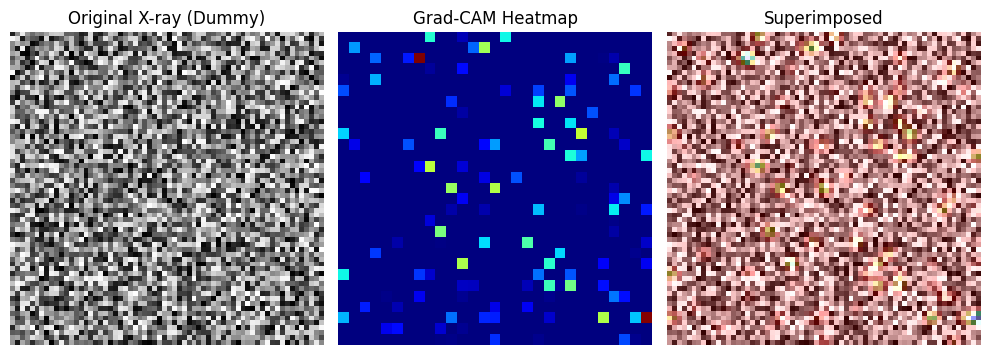

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import cv2

# 1. Dummy Data
num_samples = 100
img_height, img_width = 64, 64
num_classes = 2
X = np.random.rand(num_samples, img_height, img_width, 1).astype(np.float32)
y = np.random.randint(0, num_classes, num_samples)
y_cat = to_categorical(y, num_classes)

# 2. Functional API Model
inputs = layers.Input(shape=(img_height, img_width, 1))
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', name='last_conv')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train
model.fit(X, y_cat, epochs=2, batch_size=8, verbose=1)

# 4. Grad-CAM utility
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 5. Test image (get shape right!)
img_idx = 0
test_img = X[img_idx]                 # shape: (64, 64, 1)
input_img = np.expand_dims(test_img, axis=0)   # shape: (1, 64, 64, 1)
print("test_img shape:", test_img.shape)
print("input_img shape:", input_img.shape)

# 6. Predict
pred = model.predict(input_img)
pred_class = np.argmax(pred[0])
print(f"Model predicted class: {pred_class}")

# 7. Grad-CAM
last_conv_layer_name = 'last_conv'
heatmap = make_gradcam_heatmap(input_img, model, last_conv_layer_name, pred_index=pred_class)

# 8. Superimpose
def superimpose(img, heatmap, alpha=0.4):
    img = np.squeeze(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + np.uint8(img * 255)[..., np.newaxis]
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

superimposed_img = superimpose(test_img, heatmap)

# 9. Plot results
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(test_img), cmap='gray')
plt.title('Original X-ray (Dummy)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title('Grad-CAM Heatmap')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(superimposed_img)
plt.title('Superimposed')
plt.axis('off')
plt.tight_layout()
plt.show()